Write a program to get the buisness analytics for any single product on the basis of its price, popularity of the product . ( Assume any required data for prototype execution or collect from website).

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# from fastai.tabular.all import add_datepart
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [3]:
product_name= "GTA 5 PS5"
actual_price= 2900


In [4]:
df=pd.read_csv("synthesized data.csv")

In [5]:

df["Discount"]=round((actual_price - df["Price"])/actual_price*100)
df["IsBestSeller"]=df.IsBestSeller.map({'Yes':1,'No':0})
df.Date=pd.to_datetime(df.Date)
df=df.drop("index", axis=1)

In [6]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['Date'].dt.dayofweek >= 5
df['IsWeekend']= df.IsWeekend.map({True:1,False:0})

# Convert Month and DayOfWeek to cyclical features
df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

# Drop original Date column if necessary
# df = df.drop('Date', axis=1)

In [7]:
label_encoder = LabelEncoder()
df['Festival_Label'] = label_encoder.fit_transform(df['Festival'])

In [8]:
cols=df.columns
cols

Index(['Date', 'Price', 'Popularity', 'Sales_of_Day', 'Reviews', 'Rating',
       'Rank', 'IsBestSeller', 'Festival', 'Discount', 'Year', 'Month', 'Day',
       'DayOfWeek', 'IsWeekend', 'Month_sin', 'Month_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Festival_Label'],
      dtype='object')

In [27]:
df

,Date,Price,Popularity,Sales_of_Day,Reviews,Rating,Rank,IsBestSeller,Festival,Discount,Year,Month,Day,DayOfWeek,IsWeekend,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,Festival_Label
0,2022-01-01,2000,2500,120,80,4.4,10,0,New Year,31.0,2022,1,1,5,1,5.000000e-01,8.660254e-01,-0.974928,-0.222521,6
1,2022-01-14,2000,2700,140,85,4.5,8,1,Post New Year Sale,31.0,2022,1,14,4,0,5.000000e-01,8.660254e-01,-0.433884,-0.900969,8
2,2022-03-01,2050,2600,135,90,4.5,7,1,Holi,29.0,2022,3,1,1,0,1.000000e+00,6.123234e-17,0.781831,0.623490,3
3,2022-03-18,2241,3100,160,95,4.6,5,1,Spring Festival,23.0,2022,3,18,4,0,1.000000e+00,6.123234e-17,-0.433884,-0.900969,13
4,2022-04-15,2000,2800,145,100,4.5,6,0,Ram Navami,31.0,2022,4,15,4,0,8.660254e-01,-5.000000e-01,-0.433884,-0.900969,12
5,2022-05-01,2050,2700,140,95,4.5,7,0,Pre-Summer,29.0,2022,5,1,6,1,5.000000e-01,-8.660254e-01,-0.781831,0.623490,9
6,2022-08-10,2000,2900,150,110,4.6,6,0,Raksha Bandhan,31.0,2022,8,10,2,0,-8.660254e-01,-5.000000e-01,0.974928,-0.222521,11
7,2022-08-15,1980,3100,155,115,4.7,4,1,Independence Day Sale,32.0,2022,8,15,0,0,-8.660254e-01,-5.000000e-01,0.000000,1.000000,4
8,2022-09-01,2000,2950,140,105,4.6,5,0,Back to School,31.0,2022,9,1,3,0,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,0
9,2022-10-05,2300,3200,170,120,4.7,3,1,Diwali,21.0,2022,10,5,2,0,-8.660254e-01,5.000000e-01,0.974928,-0.222521,2


In [46]:
df.to_csv("yo.csv")

Text(0, 0.5, 'Popoularity')

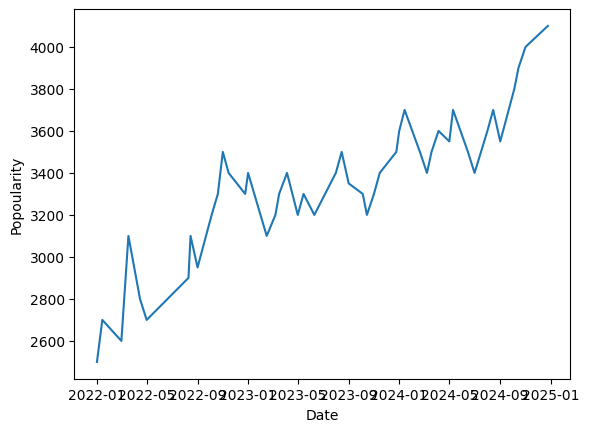

In [9]:

plt.plot(df.Date,df.Popularity)
plt.xlabel("Date")
plt.ylabel("Popoularity")


Text(0, 0.5, 'Popoularity')

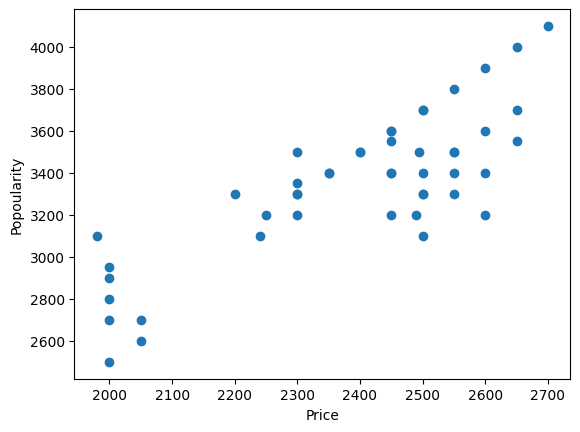

In [10]:
plt.scatter(df.Price,df.Popularity)
plt.xlabel("Price")
plt.ylabel("Popoularity")

Text(0, 0.5, 'Sales of Day')

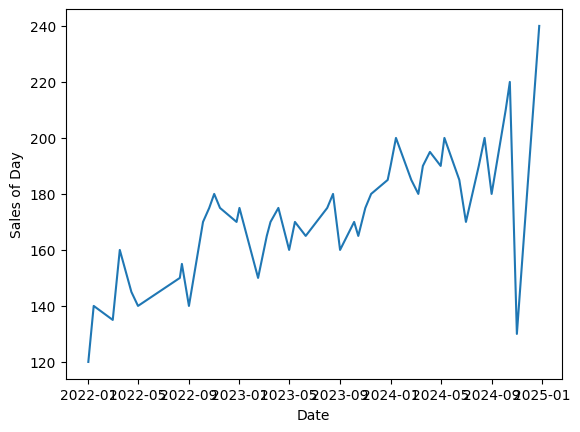

In [11]:
plt.plot(df.Date,df["Sales_of_Day"])
plt.xlabel("Date")
plt.ylabel("Sales of Day")

In [12]:
X=df[['Price',  'Reviews', 'Rating',
       'Rank', 'Discount', 'Year', 'Month', 'Day',
       'DayOfWeek', 'IsWeekend', 'Month_sin', 'Month_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Festival_Label']]
y=df[['Popularity','Sales_of_Day','IsBestSeller']]
# y_Popularity=['Popularity',]
# y_Sales_of_Day=df['Sales_of_Day']
# y_IsBestSeller=df['IsBestSeller']
Xcols=X.columns
Ycols=y.columns


In [13]:
Xnp=X.values
Ynp=y.values

In [14]:
for i, c in enumerate(X.columns):
    print(f"{c} Max, Min pre normalization: {np.max(Xnp[:, i]):0.2f}, {np.min(Xnp[:, i]):0.2f}")

# Create and adapt the Normalization layer
norm_l = tf.keras.layers.Normalization(axis=1)
norm_l.adapt(Xnp)  # learns mean, variance

# Apply normalization
Xn = norm_l(Xnp)

# Convert normalized NumPy array back to DataFrame
X_normalized = pd.DataFrame(Xn, columns=Xcols)

# Print max and min values after normalization
for i, c in enumerate(X.columns):
    print(f"{c} Max, Min post normalization: {np.max(Xn[:, i]):0.2f}, {np.min(Xn[:, i]):0.2f}")


norm_l2 = tf.keras.layers.Normalization(axis=1)
norm_l2.adapt(Ynp)

Yn=norm_l2(Ynp)

y_normalized=pd.DataFrame(Yn,columns=Ycols)

# Show the normalized DataFrame
# print(X_normalized)
# print(y_normalized)

Price Max, Min pre normalization: 2700.00, 1980.00
Reviews Max, Min pre normalization: 200.00, 80.00
Rating Max, Min pre normalization: 4.90, 4.40
Rank Max, Min pre normalization: 10.00, 1.00
Discount Max, Min pre normalization: 32.00, 7.00
Year Max, Min pre normalization: 2024.00, 2022.00
Month Max, Min pre normalization: 12.00, 1.00
Day Max, Min pre normalization: 25.00, 1.00
DayOfWeek Max, Min pre normalization: 6.00, 0.00
IsWeekend Max, Min pre normalization: 1.00, 0.00
Month_sin Max, Min pre normalization: 1.00, -1.00
Month_cos Max, Min pre normalization: 1.00, -1.00
DayOfWeek_sin Max, Min pre normalization: 0.97, -0.97
DayOfWeek_cos Max, Min pre normalization: 1.00, -0.90
Festival_Label Max, Min pre normalization: 15.00, 0.00
Price Max, Min post normalization: 1.51, -1.98
Reviews Max, Min post normalization: 1.88, -2.22
Rating Max, Min post normalization: 1.86, -2.52
Rank Max, Min post normalization: 3.47, -1.46
Discount Max, Min post normalization: 2.02, -1.51
Year Max, Min post

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)


In [57]:
print(f"X Shape {X_train.shape}")
print(f"Y Shape {y_train.shape}")


X Shape (37, 15)
Y Shape (37, 3)


Creating a simple Feed forward Sequential Dense Neural Network

In [58]:
model=Sequential([
    Input(shape=(15,)),
    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=3,activation='relu')
])

In [59]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=['mae'],

)

model.save("model.keras")

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('model.keras', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               mode='min', 
                               restore_best_weights=True)

In [60]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,163 (610.01 KB)

 Trainable params: 156,163 (610.01 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model.fit(X_train, y_train, epochs=200, batch_size=2, validation_data=(X_train, y_train),callbacks=[checkpoint, early_stopping])


Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5800 - mae: 0.4556 - val_loss: 0.5998 - val_mae: 0.4581
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5586 - mae: 0.4501 - val_loss: 0.6005 - val_mae: 0.4631
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4716 - mae: 0.4020 - val_loss: 0.6014 - val_mae: 0.4655
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5996 - mae: 0.4515 - val_loss: 0.6012 - val_mae: 0.4676
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4330 - mae: 0.4087 - val_loss: 0.6031 - val_mae: 0.4811
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6604 - mae: 0.5277 - val_loss: 0.6022 - val_mae: 0.4781
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6238 - mae: 0.5017 - val_loss: 0.6017 - val_mae: 0.4718
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6367 - mae: 0.5124 - val_loss: 0.6324 - val_mae: 0.5360
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.726

In [64]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,491 (1.79 MB)

 Trainable params: 156,163 (610.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 312,328 (1.19 MB)

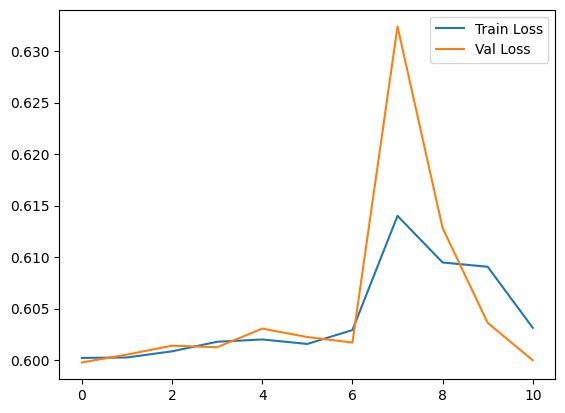

In [65]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [66]:
y_pred_s=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [67]:
mean = norm_l2.mean[0].numpy()
variance = norm_l2.variance[0].numpy()

# Reverse the normalization
y_pred = y_pred_s * np.sqrt(variance) + mean
y_test2= y_test * np.sqrt(variance) + mean

In [68]:
df2=pd.DataFrame(y_pred, columns=Ycols)
df3=pd.DataFrame(y_test2, columns=Ycols)
df4=pd.concat([df2,df3], axis=1)
df4

,Popularity,Sales_of_Day,IsBestSeller,Popularity,Sales_of_Day,IsBestSeller
0,3345.404053,172.978729,0.801383,NaN,NaN,NaN
1,3534.438477,185.905106,0.982562,NaN,NaN,NaN
2,3344.680908,172.978729,0.595745,NaN,NaN,NaN
3,3688.418457,195.868820,0.595745,NaN,NaN,NaN
4,3344.680908,172.978729,0.595745,2800.0,145.0,0.0
5,3685.405029,198.999893,1.152509,NaN,NaN,NaN
6,3422.106201,177.518051,0.903875,NaN,NaN,NaN
7,3344.680908,172.978729,0.749232,NaN,NaN,NaN
8,3344.680908,172.978729,0.595745,NaN,NaN,NaN
9,3344.680908,172.978729,0.595745,NaN,NaN,NaN


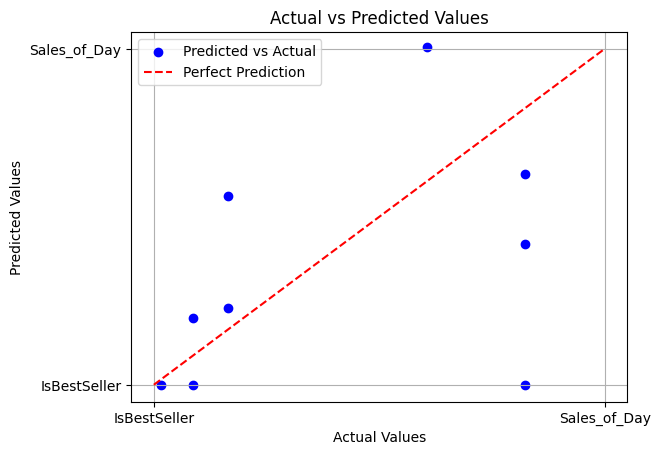

In [69]:
y_actual=y_test
plt.scatter(y_actual, y_pred_s, color='blue', label='Predicted vs Actual')

# Plot the diagonal line (y = x) for reference
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

plt.show()